In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
import zipfile
import os
from prog_models.data_models import LSTMStateTransitionModel
from prog_models.models import BatteryElectroChemEOD
from prog_models.utils import *

%load_ext tensorboard
%load_ext autoreload
%autoreload 2

results = {}
keras = tf.keras
K = tf.keras.backend

In [2]:
def get_model_sparsity(model):
    def _get_sparsity(weights):
        return 1.0 - np.count_nonzero(weights) / float(weights.size)

    sparsity = 0
    count = 0
    for layer in model.layers:
        if isinstance(layer, pruning_wrapper.PruneLowMagnitude):
            prunable_weights = layer.layer.get_prunable_weights()
            if prunable_weights:
                for weight in prunable_weights:
                    s = _get_sparsity(K.get_value(weight))
                    sparsity += s
                    count += 1
    if count == 0 or sparsity == 0:
        return 0
    else:
        return sparsity / count
     
    
def get_size_mb(fname):
    return os.path.getsize(fname) / 1024 / 1024
    
    
def add_results(results, name, rmse, h5_size, tflite_size, zipped_size, n_params, sparsity):
    results[name] = {}
    results[name]['rmse'] = rmse
    results[name]['h5_size'] = h5_size
    results[name]['tflite_size'] = tflite_size
    results[name]['zipped_size'] = zipped_size
    results[name]['n_params'] = n_params
    results[name]['sparsity'] = sparsity
    return results


def gzip_model(file):
    
    with zipfile.ZipFile(f'{file}.zip', 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(file)

    return os.path.getsize(f'{file}.zip') / 1024 / 1024

def future_loading(t, x=None):
    return batt.InputContainer({'i': 3})

def future_loading2(t, x = None):
    global t_counter, x_counter
    z = batt.output(x_counter)
    z = m_batt.InputContainer({'i': 3, 't_t-1': z['t'], 'v_t-1': z['v'], 'dt': t - t_counter})
    x_counter = batt.next_state(x_counter, future_loading(t), t - t_counter)
    t_counter = t
    return z

def compare_models():
    global t_counter, x_counter
    # Step 3: Simulate with model
    t_counter = 0
    x_counter = batt.initialize()

    # Use a new dt, not used in training. 
    # Using a dt not used in training will demonstrate the model's 
    # ability to handle different timesteps not part of training set
    res_true = batt.simulate_to_threshold(future_loading, dt=1, save_freq=1)
    res_pred = m_batt.simulate_to(res_true.times[-1], future_loading2, dt=1, save_freq=1)

    # Step 5: Compare pred
    true = {}
    true['name'] = 'true'
    true['temp'] = [val['t'] for val in res_true.outputs]
    true['voltage'] = [val['v'] for val in res_true.outputs]

    pred = {}
    pred['name'] = 'pred'
    pred['temp'] = [val['t'] for val in res_pred.outputs]
    pred['voltage'] = [val['v'] for val in res_pred.outputs]

    traces = [true, pred]
    params = ['temp', 'voltage']

    fig = plt.figure(figsize=(8,4))
    i = 1
    for param in params:
        plt.subplot(2,1,i)
        i += 1
        for trace in traces:
            plt.plot(trace[param], label=f'{trace["name"]} - {param}') 
        plt.legend()
    plt.show()

In [3]:
batt = BatteryElectroChemEOD(process_noise = 0, measurement_noise=0)
print(batt)

future_loading_eqns = [lambda t, x=None, load=load: batt.InputContainer({'i': 1+1.5*load}) for load in range(6)]
# Generate data with different loading and step sizes
# Adding the step size as an element of the output
training_data = []
for i in range(9):
    dt = i/3+0.25
    for loading_eqn in future_loading_eqns:
        d = batt.simulate_to_threshold(loading_eqn, save_freq=dt, dt=dt) 
        u = np.array([np.hstack((u_i.matrix[:][0].T, [dt])) for u_i in d.inputs], dtype=float)
        z = d.outputs
        training_data.append((u, z))
        

BatteryElectroChemEOD Prognostics Model (Events: ['EOD'])


In [4]:
# Step 2: Generate Model
print('Building model...')
name = 'original'
m_batt = LSTMStateTransitionModel.from_data(
    training_data,  
    window=12, 
    epochs=5, 
    units=16,  # Additional units given the increased complexity of the system
    inputs = ['i', 'dt'],
    outputs = ['t', 'v'],
    process_noise=0,
    measurement_noise=0,
    optimizer='adam',
    checkpoint=f'{name}.keras')

Building model...
Epoch 1/5
3060/3060 [==============================] - 21s 6ms/step - loss: 0.0842 - root_mean_squared_error: 0.2902 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1040
Epoch 2/5
3060/3060 [==============================] - 17s 6ms/step - loss: 0.0624 - root_mean_squared_error: 0.2498 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1026
Epoch 3/5
3060/3060 [==============================] - 17s 6ms/step - loss: 0.0627 - root_mean_squared_error: 0.2505 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0700
Epoch 4/5
3060/3060 [==============================] - 17s 6ms/step - loss: 0.0620 - root_mean_squared_error: 0.2490 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1003
Epoch 5/5
3060/3060 [==============================] - 17s 5ms/step - loss: 0.0621 - root_mean_squared_error: 0.2493 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1036


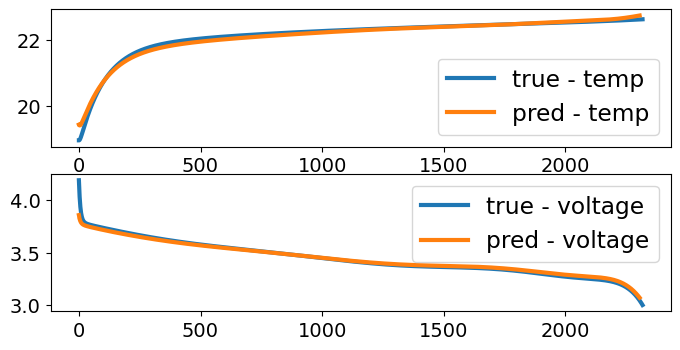

In [5]:
compare_models()

In [20]:
m_batt.reduce(training_data, epochs=1)

reducing model size
3060/3060 [==============================] - 54s 15ms/step - loss: 0.0765 - root_mean_squared_error: 0.2766 - val_loss: 0.0160 - val_root_mean_squared_error: 0.1267


INFO:tensorflow:Assets written to: C:\Users\timda\AppData\Local\Temp\tmpjsc1yqpo\assets


INFO:tensorflow:Assets written to: C:\Users\timda\AppData\Local\Temp\tmpjsc1yqpo\assets


INFO:tensorflow:Assets written to: C:\Users\timda\AppData\Local\Temp\tmpd76y2v_s\assets


INFO:tensorflow:Assets written to: C:\Users\timda\AppData\Local\Temp\tmpd76y2v_s\assets


In [25]:
r_batt = m_batt.creduce(training_data, epochs=1)

AttributeError: 'LSTMStateTransitionModel' object has no attribute 'inputs'

In [26]:
m_batt.__dict__.keys()

dict_keys(['outputs', 'inputs', 'states', 'n_inputs', 'n_states', 'n_events', 'n_outputs', 'n_performance', 'StateContainer', 'InputContainer', 'OutputContainer', 'apply_process_noise', 'apply_measurement_noise', 'parameters', 'model', 'model_bytes', 'pruned', 'pruned_bytes', 'quantized_bytes', 'params'])

In [15]:
name = 'quantized'
gzip_model(f'{name}.tflite')

0.0045413970947265625

# comparison

In [13]:
import time

In [22]:
names = ['pruned', 'quantized']
for name in names:
    #interpreter = tf.lite.Interpreter(model_path=f'{name}.tflite')
    interpreter = tf.lite.Interpreter(model_content=m_batt.pruned_bytes)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    input_shape = input_details[0]['shape']

    input_data = x_test[i].reshape(1,-1).astype('float32')
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    interpreter.get_tensor(output_details[0]['index'])


NameError: name 'x_test' is not defined

In [15]:
input_shape

array([ 1, 12,  4])

In [14]:
names = ['pruned', 'quantized']
for name in names:
    interpreter = tf.lite.Interpreter(model_path=f'{name}.tflite')
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    input_shape = input_details[0]['shape']

    res = []
    t1 = time.time()
    for i in range(len(x_test)):
        input_data = x_test[i].reshape(1,-1).astype('float32')
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        res.append(interpreter.get_tensor(output_details[0]['index']))
    t2 = time.time()
    elapsed = t2 - t1
    speed = elapsed / len(x_test)
    res = np.array(res).flatten()
    res = np.round(res).astype('int')
    acc = 1 - sum(abs(y_test - res))/len(y_test)
    size = get_size_mb(f'{name}.tflite')
    print(f'name: {name}, size: {size}, acc: {acc}, time: {elapsed}, speed: {speed}')

NameError: name 'x_test' is not defined

# imports

In [ ]:
import numpy as np
import tensorflow as tf
import os
# base_dir = os.path.dirname(os.getcwd())
# print(base_dir)
# import sys
# sys.path.insert(1, base_dir)
# from package.api import DB as api
# import package.utils as utils
# import package.tuning as tuning
# utils.check_gpu()
import time
import zipfile
import tempfile
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.python.core.sparsity.keras import prune
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_schedule
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
from keras.utils.layer_utils import count_params

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

%load_ext tensorboard

keras = tf.keras
K = tf.keras.backend
results = {}

def get_model_sparsity(model):
    def _get_sparsity(weights):
        return 1.0 - np.count_nonzero(weights) / float(weights.size)

    sparsity = 0
    count = 0
    for layer in model.layers:
        if isinstance(layer, pruning_wrapper.PruneLowMagnitude):
            prunable_weights = layer.layer.get_prunable_weights()
            if prunable_weights:
                for weight in prunable_weights:
                    s = _get_sparsity(K.get_value(weight))
                    sparsity += s
                    count += 1
    if count == 0 or sparsity == 0:
        return 0
    else:
        return sparsity / count
    
    
    
def get_size_mb(fname):
    res = !ls -l | grep $fname
    return round(int(res[0].split(os.getlogin())[-1].lstrip().split(' ')[0]) / 1024 / 1024, 2)
    
    
    
def add_results(results, name, score, acc, h5_size, tflite_size, zipped_size, n_params, sparsity):
    results[name] = {}
    results[name]['score'] = score
    results[name]['acc'] = acc
    results[name]['h5_size'] = h5_size
    results[name]['tflite_size'] = tflite_size
    results[name]['zipped_size'] = zipped_size
    results[name]['n_params'] = n_params
    results[name]['sparsity'] = sparsity
    return results



def gzip_model(file):
    
    with zipfile.ZipFile(f'{file}.zip', 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(file)

    return os.path.getsize(f'{file}.zip') / 1024 / 1024